In [1]:
import os
import sys
import time
import warnings

import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes

from typing import List

from pyROMs.pod import POD

from utils import *

warnings.filterwarnings('ignore')

Define Routines

In [14]:
def truncation_study(dataset, params,
                     test_size, seed, interior_error):
    """Perform a mode truncation study."""
    vars = params["vars"]
    tau = params["tau"]
    interp = params["interp"]
    epsilon = params["epsilon"]

    # Setup storage
    out = {'tau': [], 'n_modes': [],
           'mean': [], 'max': [], 'min': []}

    # Setup POD model
    pod = POD(svd_rank=1.0-tau,
              method=interp,
              epsilon=epsilon)

    # Setup training/validation sets
    splits = dataset.train_test_split(
        variables=vars, test_size=test_size,
        seed=seed, interior_only=interior_only)
    X_train, X_test, Y_train, Y_test = splits

    # Run study
    taus = [10.0**i for i in range(-16, 0)]
    for tau in taus:

        # Construct POD model, predict test data
        pod.fit(X_train, Y_train, svd_rank=1.0-tau)
        X_pod = pod.predict(Y_test)

        # Format datasets
        X_pod = dataset.unstack_simulation_vector(X_pod)
        X_test = dataset.unstack_simulation_vector(X_test)

        # Compute simulation errors
        errors = np.zeros(len(X_test))
        for i in range(len(X_test)):
            errors[i] = norm(X_test[i]-X_pod[i])/norm(X_test[i])

        # Store results
        out['tau'].append(tau)
        out['n_modes'].append(pod.n_modes)
        out['mean'].append(np.mean(errors))
        out['max'].append(np.max(errors))
        out['min'].append(np.min(errors))
    return out


def plot_results(results):
    """Plot the truncation study results."""
    fig: Figure = plt.figure()
    for i in range(2):
        ax: Axes = fig.add_subplot(1, 2, i + 1)
        if i == 0:
            ax.set_xlabel("# of Modes", fontsize=12)
            ax.set_ylabel("$L^2$ Error", fontsize=12)
            ax.semilogy(results['n_modes'], results['mean'],
                        '-*b', label="Mean")
            ax.semilogy(results['n_modes'], results['max'],
                        '-or', label="Maximum")
            ax.semilogy(results['n_modes'], results['min'],
                        '-+k', label="Minimum")
        else:
            ax.set_xlabel("$\\tau$", fontsize=12)
            ax.loglog(results['tau'], results['mean'],
                      '-*b', label="Mean")
            ax.loglog(results['tau'], results['max'],
                      '-or', label="Maximum")
            ax.loglog(results['tau'], results['min'],
                      '-+k', label="Minimum")
        ax.legend(fontsize=12)
        ax.grid(True)
    plt.tight_layout()

Parse the Data

In [6]:
problem_name = input("What problem? ")

print("Loading and formating the data...")
t_start = time.time()
dataset = get_data(problem_name)
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")

Loading and formating the data...
Loading the data took 12.801035 s


Perform the Truncation Study

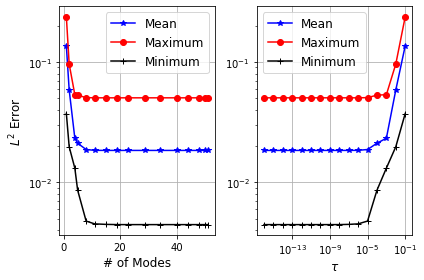

In [15]:
params = get_params(problem_name)

test_size = 0.2
seed = 12
interior_only = False

res = truncation_study(dataset, params, test_size,
                       seed, interior_only)
plot_results(res)
